<a href="https://colab.research.google.com/github/sahasramahakala/aiml-batch-16/blob/main/%F0%9F%8C%BD_Maize_Leaf_Disease_Detection_w_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'corn-or-maize-leaf-disease-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F967819%2F1637108%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T055841Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b5993b979d45566f951130b855575655d288bcb54a1567279f08b7bf68b59bfa8560dd2211f2b0204c84340bdf591688cd7132c4cab9433bffc2890e5b7c0069c9c17c351846f228ead506feecb50e6b22083034db34593a40b86daeb0ce06b035b71a56bf7485b9db7c5eea7ef3f1afe3a73035803d2518ed43ff2520add05684546a846e32d2516958ee7a1b105e6996e55a61bd1b6abeb1250619dd45c6383fcfa9350d88bba1f1c6efdd0c908a1b95a92612e9f50b2c6c0353690c74ffda22b14bdbdd714f2e2d171c8846a0c84acd5924396f64eb18f359415ec2534ef99654acff6f97cccd13e65ea947694c9d905637eea734186a115e62f274702b4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 168591426 bytes downloaded
Downloaded and uncompressed: corn-or-maize-leaf-disease-dataset
Data source import complete.


## 🚨 [Hold up! Before you go anywhere, you've gotta check out my work with the Rice Leaf Disease Image Dataset.](https://www.kaggle.com/code/ohagwucollinspatrick/rice-leaf-disease-detection-w-cnn-kera/notebook?scriptVersionId=167343668)

## 🚀 Upvoting and Commenting
Hey there! While I've been having a blast tinkering with this dataset, I wouldn't mind a little sprinkle of "constructive" feedback and perhaps some generous upvotes, if you're feeling generous. I've been diving headfirst into the world of Data Science for a solid year and a half now, and let me tell ya, witnessing all these jaw-dropping projects on this platform has been quite the ride.

### 📝 Housekeeping Stuff:
1. So, I thought to myself, "Hey, why not sprinkle in some emojis? They seem to be the secret sauce for snagging those upvotes." Can't hurt, right? 🤓

2. Now, here's the scoop: I've noticed that one of our prediction classes is kind of playing hard to get, with fewer samples than the others. And let me tell you, my model's been breaking a sweat trying to figure it out. I've thrown some image augmentation into the mix, and while it's improved overall predictions, that pesky class still isn't playing nice. Any brilliant suggestions will be well appreciated. 💡

# 📥 Installing Libraries

In [4]:
!pip install livelossplot

# ➡️ Importing Libraries

> **Libraries imported as needed.**

# 🪵 Loading Datasets

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Define functions for loading and resizing images
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [7]:
# Define the function to load each image class (target) stored by individual directory.
# Each class directory containing their respective images
def load_image_class_by_directory(image_dir):
    # Load and resize images
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):  # Assuming images are in jpg or JPG format
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [8]:
# Display some images
def display_images(images, num_images_to_display = 6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        # Convert the image to a supported depth (e.g., CV_8U) before color conversion
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
        axes[i].axis('off')
    plt.show()

Num of images: 1145
Single image shape before flattening: (128, 128, 3)


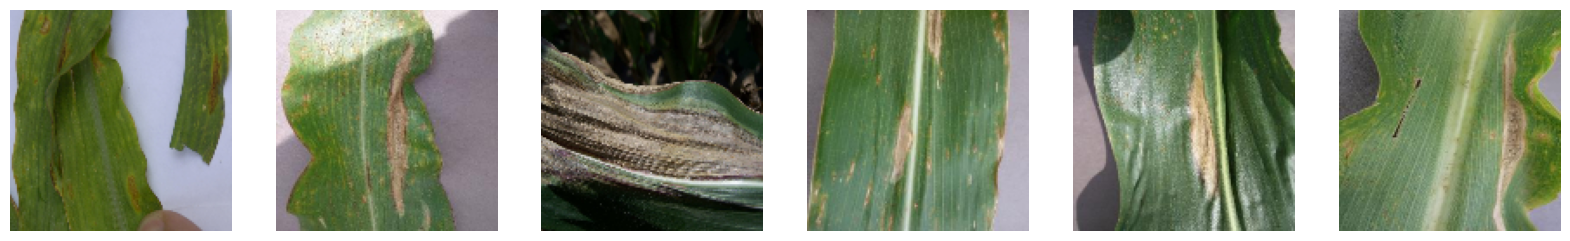

In [9]:
# Define the directory containing images
image_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight"
images_Blight = load_image_class_by_directory(image_dir)
display_images(images_Blight)

Num of images: 1306
Single image shape before flattening: (128, 128, 3)


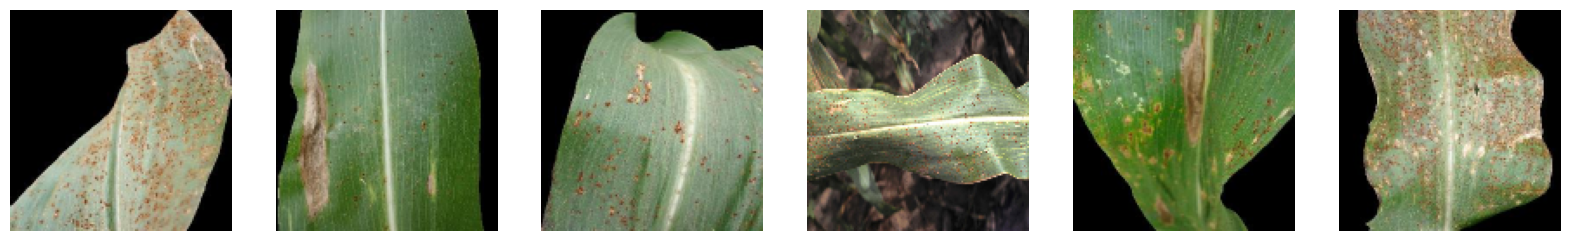

In [10]:
# Define the directory containing images
image_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust"
images_Common_Rust = load_image_class_by_directory(image_dir)
display_images(images_Common_Rust)

Num of images: 574
Single image shape before flattening: (128, 128, 3)


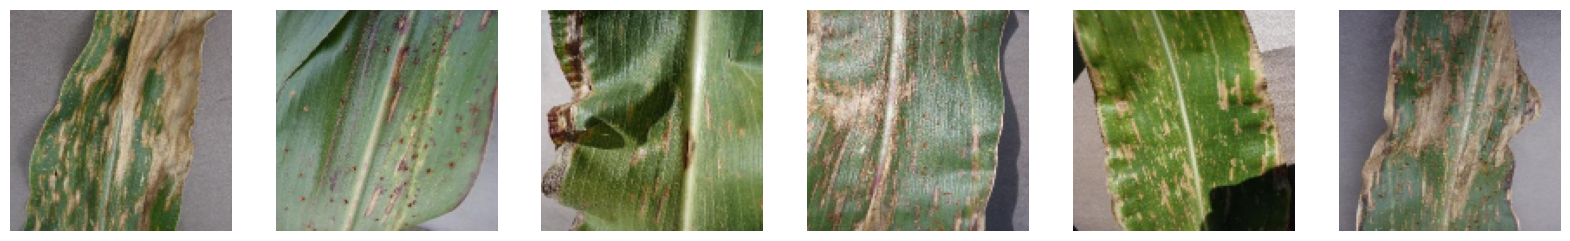

In [11]:
# Define the directory containing images
image_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot"
images_Gray_Leaf_Spot = load_image_class_by_directory(image_dir)
display_images(images_Gray_Leaf_Spot)

Num of images: 1162
Single image shape before flattening: (128, 128, 3)


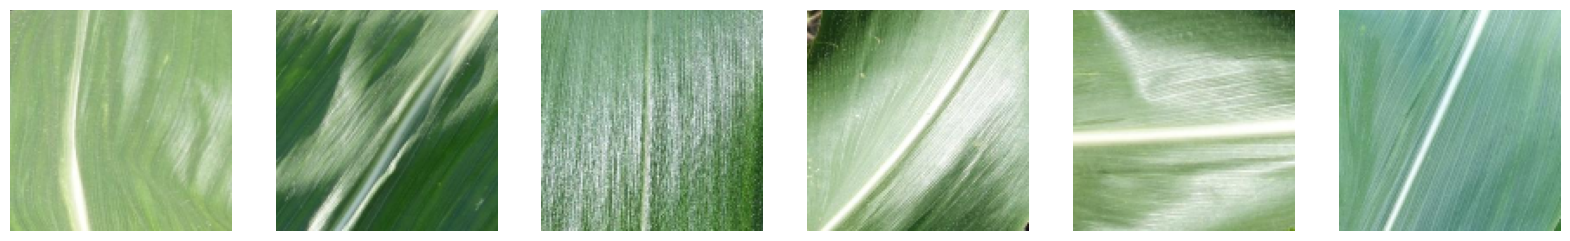

In [12]:
# Define the directory containing images
image_dir = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Healthy"
images_Healthy = load_image_class_by_directory(image_dir)
display_images(images_Healthy)

# 🔎 Inspecting Samples

In [13]:
# Define class labels
classes = {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
inverted_classes = {0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

images_lst_lst = [images_Blight, images_Common_Rust, images_Gray_Leaf_Spot, images_Healthy]

# Dictionary to store the number of image samples
classes_dict = {}
for i, images in enumerate(images_lst_lst):
    classes_dict.update({inverted_classes[i]: len(images)})
    print(f'Disease: {inverted_classes[i]} --- Images: {len(images)}')

Disease: Blight --- Images: 1145
Disease: Common_Rust --- Images: 1306
Disease: Gray_Leaf_Spot --- Images: 574
Disease: Healthy --- Images: 1162


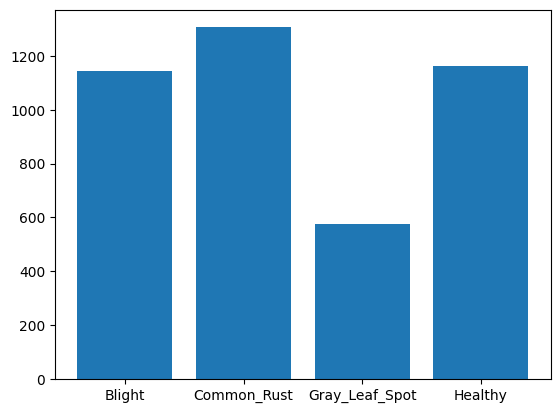

In [14]:
# Now, plot the classes
plt.bar(*zip(*classes_dict.items()))
plt.show()

There is a **class imbalance** with fewer cases of **Gray_Leaf_Spot**. This may affect model's ability to recognize the class, or do so with high confidence at least.

# 🏷️ Assigning Class Labels
Pick the number of images to set aside as **test** set. The algorithm should not see this data as it will be used for later evaluations.

Add a class label for each image. This is done by first flattening the image from 2D to 1D, and then appending the class number to it (such as 0 for Blight, etc.)

In [15]:
# Function to flatten the RGB values from 2D to 1D, returns a numpy array
def flatten_images(images):
    data_flattened = []
    for image in images:
        flattened_image = image.reshape(-1)  # Flatten the image
        data_flattened.append(flattened_image)


    print(f"Num of images: {len(data_flattened)}")
    print(f"Single image shape after flattening: {data_flattened[0].shape}")

    # Convert data to numpy array for further processing
    data_flattened = np.array(data_flattened)
    return data_flattened

In [16]:
# Function to assign class labels: returns a numpy array
def assign_image_class_label(images, class_label = int):
    data_labeled = []
    # Flatten the images
    data_flattened = flatten_images(images)

    for image in data_flattened:
        # Assign class label
        data_labeled.append(np.concatenate([image, [class_label]]))

    print(f"Num of images: {len(data_labeled)}")
    print(f"Single data shape with label: {data_labeled[0].shape} --- Class label: {class_label}\n")

    # Convert data to numpy array for further processing
    data_labeled = np.array(data_labeled)
    return data_labeled

In [17]:
# Function to concatenate the arrays into a pandas dataframe, horizontally
def concat_arrays_to_dataframe(arrays = []):
    # Combine to a single dataframe, vertically
    dataset = np.concatenate(arrays, axis = 0)

    # Number of pixel columns, excluding the last label column
    num_pix = dataset.shape[1] - 1

    # Modify the column names
    col_lst = [f"pixel{col}" for col in range(num_pix)]
    # Append the name of the last column as label
    col_lst.append("label")

    # Convert to a dataframe and add column names
    df_dataset = pd.DataFrame(dataset, columns = col_lst)

    return df_dataset

In [18]:
# Split the image files into train - test set.
def split_train_test_files(images_lst_lst = [], num_test_set = int):
    train_images_lst_lst = []
    test_images_lst_lst = []
    # Iterate through the first class of images
    for images in images_lst_lst:
        train_set = images[num_test_set:]
        test_set = images[:num_test_set]

        train_images_lst_lst.append(train_set)
        test_images_lst_lst.append(test_set)

    return train_images_lst_lst, test_images_lst_lst

In [19]:
# Number of images to set aside as test set per class
num_test_set = 20

# Split the image files into train - test set.
train_images, test_images = split_train_test_files(images_lst_lst, num_test_set)

In [20]:
images_lst_array = []
# Iterate through the classes, the class index i will represent the class name/label
for i, images in enumerate(train_images):
    # Assign label to each of the images
    labeled = assign_image_class_label(images, i)
    images_lst_array.append(labeled)

Num of images: 1125
Single image shape after flattening: (49152,)
Num of images: 1125
Single data shape with label: (49153,) --- Class label: 0

Num of images: 1286
Single image shape after flattening: (49152,)
Num of images: 1286
Single data shape with label: (49153,) --- Class label: 1

Num of images: 554
Single image shape after flattening: (49152,)
Num of images: 554
Single data shape with label: (49153,) --- Class label: 2

Num of images: 1142
Single image shape after flattening: (49152,)
Num of images: 1142
Single data shape with label: (49153,) --- Class label: 3



In [21]:
# Concatenate arrays to dataframe
df_images = concat_arrays_to_dataframe(images_lst_array)
df_images.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel49143,pixel49144,pixel49145,pixel49146,pixel49147,pixel49148,pixel49149,pixel49150,pixel49151,label
0,149,130,139,147,128,137,146,127,136,146,...,36,76,63,35,77,60,33,78,59,0
1,74,133,125,68,127,119,77,136,128,77,...,147,133,135,148,134,136,150,136,138,0
2,85,86,94,100,99,108,119,115,124,130,...,147,140,147,145,138,145,145,138,145,0
3,64,49,53,67,52,56,66,51,55,67,...,102,124,105,91,113,94,80,102,83,0
4,129,114,122,128,113,121,129,114,122,131,...,122,115,128,121,114,127,119,112,125,0


# ✂️ Train Val Split

In [22]:
from sklearn.model_selection import train_test_split
import random

In [23]:
X_images = df_images.drop("label", axis = 1)
y_images = df_images["label"]

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_images, y_images, test_size = 0.25, random_state = 2, shuffle=True)
print("Shape of train X:", X_train.shape)
print("Shape of train Y:", y_train.shape)
print("Shape of val X:", X_val.shape)
print("Shape of val Y:", y_val.shape)

Shape of train X: (3080, 49152)
Shape of train Y: (3080,)
Shape of val X: (1027, 49152)
Shape of val Y: (1027,)


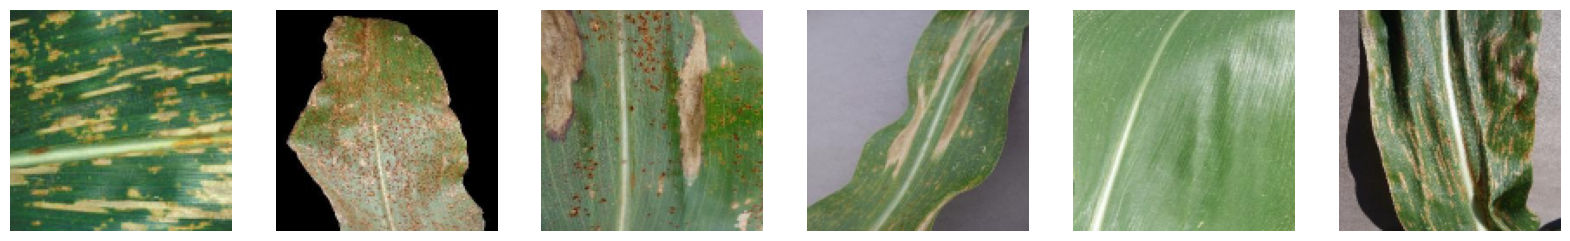

In [25]:
# Display some images before scaling
X_train_RGB = np.array(X_train).reshape(-1, 128, 128, 3)
display_images(X_train_RGB)

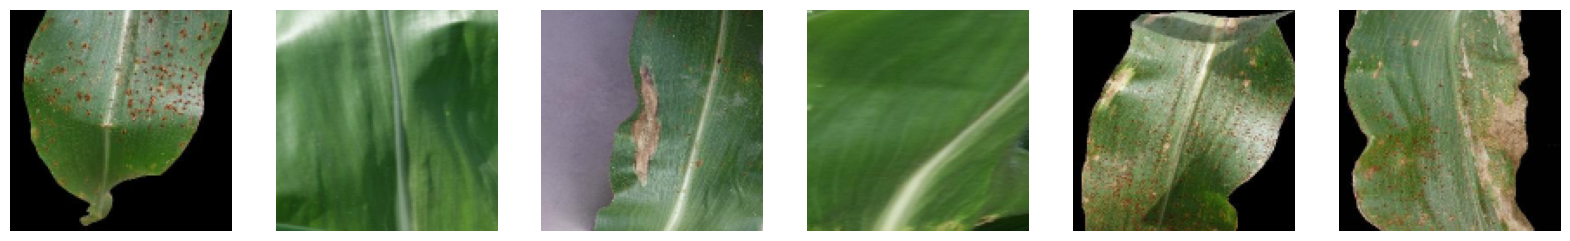

In [26]:
# Display some images before scaling
X_val_RGB = np.array(X_val).reshape(-1, 128, 128, 3)
display_images(X_val_RGB)

# 🆗 Normalizing Dataset

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
# The pixel values ranges from 0 to 255. The MinMaxScaler makes it from 0 to 1.
# This reduces the magnitude sensitivity of the activation function for the choosen ML algorithm.
scaler = MinMaxScaler(feature_range = (0, 1))

# Convert to numpy array to remove feature names before fitting
scaler = scaler.fit(np.array(X_train))
X_train_np = scaler.transform(np.array(X_train))
X_val_np = scaler.transform(np.array(X_val))

# Reshape to RGB format
X_train_RGB = np.array(X_train_np).reshape(-1, 128, 128, 3)
X_val_RGB = np.array(X_val_np).reshape(-1, 128, 128, 3)

# Reshape targets
y_train = y_train.values.reshape(len(y_train), 1)
y_val = y_val.values.reshape(len(y_val), 1)

In [29]:
print("Shape of train X:", X_train_RGB.shape)
print("Shape of train Y:", y_train.shape)
print("Shape of val X:", X_val_RGB.shape)
print("Shape of val Y:", y_val.shape)

Shape of train X: (3080, 128, 128, 3)
Shape of train Y: (3080, 1)
Shape of val X: (1027, 128, 128, 3)
Shape of val Y: (1027, 1)


# 🏗️ Building Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

# Target variable needs one-hot encoding to ensure each example has a probability of 1.0 for its actual class and 0.0 for others.
# Use Keras to_categorical() function for achieving this.
from tensorflow.keras.utils import to_categorical

# Draw live chart of accuracy of neural network
from livelossplot import PlotLossesKeras

In [31]:
# Shape of a single image
input_shape = X_train_RGB[0].shape
num_train_images = len(X_train_RGB)
# Number of classes to be predicted
num_classes = 4
print(f'Single image shape: {input_shape}')
print(f'Number of train images: {num_train_images}')

Single image shape: (128, 128, 3)
Number of train images: 3080


Here comes the model architecture and its components.

In [32]:
# Initialize the sequential model
model = Sequential()

# Add an input layer with the specified input shape
model.add(Input(shape=input_shape))

# Add a convolutional layer with 128 filters of size 3x3, using ReLU activation function
model.add(Conv2D(128, (3, 3), activation="relu"))

# Add a max-pooling layer with a filter size of 2x2
model.add(MaxPooling2D((2, 2)))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Add another convolutional layer with 64 filters of size 3x3, using ReLU activation function
model.add(Conv2D(64, (3, 3), activation="relu"))

# Add another max-pooling layer with a filter size of 2x2
model.add(MaxPooling2D((2, 2)))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Flatten the output of the previous layers
model.add(Flatten())

# Add a dense layer with 256 neurons and ReLU activation function
model.add(Dense(256, activation="relu"))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Add a dense output layer with the number of classes and softmax activation function
model.add(Dense(num_classes, activation="softmax"))

# Compile the model with categorical crossentropy loss and Stochastic Gradient Descent optimizer
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [33]:
# Initialize Image Augmentation
train_datagen = ImageDataGenerator(rotation_range = 10,  # rotation
                                   width_shift_range = 0.1,  # horizontal shift
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1) # zoom

In [34]:
# Initialize regularization parameters - how many epochs to wait before training stops, if there is no further improvement
monitor_val_loss = EarlyStopping(monitor = "val_loss",
                                 min_delta = 1e-3,
                                 patience = 20, # Wait 5 more epochs
                                 verbose = 1,
                                 mode = "auto",
                                 restore_best_weights = True)

In [5]:
# Target variable needs one-hot encoding to ensure each example has a probability of 1.0 for its actual class and 0.0 for others.
# Use Keras to_categorical() function for achieving this.

epochs = 100
batch_size = 64

# Using the flow method to augment the image on the fly.
training_data = train_datagen.flow(X_train_RGB, to_categorical(y_train), batch_size = batch_size)

# Model evaluation
validation_data = (X_val_RGB, to_categorical(y_val))

history = model.fit(training_data,
                    epochs = epochs,
                    steps_per_epoch = num_train_images // batch_size, # Number of iterations per epoch
                    batch_size = batch_size,
                    validation_data = validation_data,
                    callbacks = [PlotLossesKeras(), monitor_val_loss], #live chart
                    verbose = 1
                   )

NameError: name 'train_datagen' is not defined

In [6]:
# Save model
model.save("/kaggle/working/disease_detector_model.keras")

NameError: name 'model' is not defined

# 🧐 Evaluating Model
 Recall that first n images haven't been seen by the algorithm.

In [ ]:
# Function to scale and reshape the images for each class
def scale_and_reshape_images(flattened_images_lst = []):
    images_scaled_RGB_lst = []
    for images in flattened_images_lst:
        # Scale images using same scaller used for the train and val set
        images_scaled = scaler.transform(images)
        # Reshape to RGB format
        images_scaled_RGB = np.array(images_scaled).reshape(-1, 128, 128, 3)

        images_scaled_RGB_lst.append(images_scaled_RGB)
    return images_scaled_RGB_lst

In [ ]:
# Display a single image
def display_image(image_single):
    image_flat = image_single.reshape(1, -1) # Flatten image
    image_inv = scaler.inverse_transform(image_flat) # Inverse transform image
    image_reshaped = image_inv.reshape(128, 128, 3)

    image = image_reshaped.astype(np.uint8)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# Interprete model prediction: returns the predicted class and the confidence level in %
def interpret_model_prediction(predictions):
    # Convert inferences to list and
    pred_lst = predictions[0,:].tolist()
    # Get the max value
    max_proba = max(pred_lst)
    # Get the index position of the max_probability
    pred_idx = pred_lst.index(max_proba)

    return pred_idx, max_proba

In [ ]:
# Define the function to make the inferences/predictions.
# Takes the actual value (String) and the image index (int from 0 to n, where n is the num_test_set)
def make_predictions(scaled_RGB_lst, image_class = '', image_idx = int):
    # Get the numerical value of the class form the defined classes dictionary
    class_val = classes[image_class]

    # Get the single image
    image_single = scaled_RGB_lst[class_val][image_idx]

    # Make prediction for one image. Has to be reshaped
    pred = model.predict(image_single.reshape(1, 128, 128, 3))

    # Interpret model predictions
    pred_class, confidence = interpret_model_prediction(pred)

    # Display image
    display_image(image_single)

    print(f"Actual: {image_class}")
    print(f"Predicted: {list(classes.keys())[pred_class]}")
    print(f'Confidence: {round(confidence, 4)}')

In [ ]:
# Flatten the images
images_lst_array = []
for images in test_images:
    # Function returns two values
    flattened = flatten_images(images) # num_test_set is the number of images set aside as test set

    images_lst_array.append(flattened)

In [ ]:
# Normalize and reshape the images for each class
images_scaled_RGB_lst = scale_and_reshape_images(images_lst_array)

In [ ]:
# Keys from the classes dictionary defined above
class_keys = list(classes.keys())
# Image index from the test set
image_idx = 2
for key in class_keys:
    make_predictions(images_scaled_RGB_lst, key, image_idx)

# 🚀 Deploying Model
In order to be able to deploy our model, we want to consider two scenarios:
1. The user sends a single image for inference.
2. The user sends multiple images for inference.

We want to be able to handle both scenarios in the function(s) that does the preprocessing of the image(s).